In [1]:
from enum import Enum

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.express as px

from sklearn import decomposition
from sklearn import preprocessing

import statistics as stats
from scipy.stats import zscore

import mgen

In [2]:
def genData(m, c, size=20, noiseFactor=0.3):
    # y=mx+c
    xs = np.random.uniform(size=size)
    ys = [m * x**2 + c + np.random.normal() * noiseFactor for x in xs]
    return xs, ys

def gen3dData(m, c, size=20, noiseFactor=0.3):
    # y=mx+c
    xs = np.random.uniform(size=size)
    ys = [m * x**2 + c + np.random.normal() * noiseFactor for x in xs]
    zs = [m * x**2 + c + np.random.normal() * noiseFactor for x in xs]
    return xs, ys, zs

def genNdData(n=3, size=20, noiseFactor=0.3):
    variables = np.zeros((n, size))
    variables[0] = xs = np.random.uniform(size=size)

    for dim in range(1, n):
        variables[dim] = [np.random.normal() * x**(dim+1) + np.random.normal() * noiseFactor for x in xs]

    return variables

In [3]:
normalize = lambda arr: preprocessing.normalize([arr])[0]

# Data creation

In [4]:
# y = mx+c
m = 3
c = 4

('Variance: ', 0.01457917736931003)

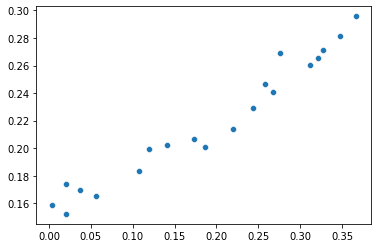

In [5]:
xs, ys = genData(m, c, size=20, noiseFactor=0.3)
xs = normalize(xs)
ys = normalize(ys)

sns.scatterplot(x=xs, y=ys)

"Variance: ", stats.variance(xs)

# PCA (sklearn)

In [6]:
# PCA
X = np.ndarray.transpose(np.array([xs, ys]))

pca = decomposition.PCA(n_components=1)
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.99512303])

<AxesSubplot:>

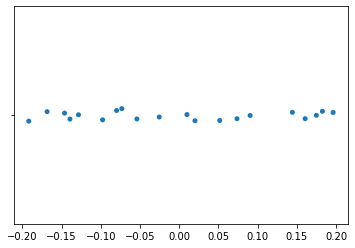

In [7]:
# Plot PCA
xs_reduced = np.transpose(X_reduced)[0]
sns.stripplot(x=xs_reduced, jitter=0.03)

# My approximation

In [8]:
vector = [1,0]

rotation_degrees = 90
rotation_radians = np.radians(rotation_degrees)

plane_v1 = np.array([1, 0])
plane_v2 = np.array([0, 1])

M = mgen.rotation_from_angle_and_plane(rotation_radians, plane_v1, plane_v2)
M.dot(vector)

array([1.11022302e-16, 1.00000000e+00])

In [9]:
def unzip(xs):
    return list( zip(*xs) )

## In 2D

In [10]:
def rotate(vec, angle_deg):
    angle_rad = np.radians(angle_deg)
    M = mgen.rotation_from_angle(angle_rad)
    return M.dot(vec)

def rotateAll(vectors, angle_deg):
    angle_rad = np.radians(angle_deg)
    M = mgen.rotation_from_angle(angle_rad)
    return [M.dot(v) for v in vectors]

In [11]:
def xsOf(vectors):
    return list( list(unzip(vectors))[0] )

def ysOf(vectors):
    return list( list(unzip(vectors))[1] )

In [12]:
def plot1d(xs):
    sns.stripplot(x=xs, jitter=0.03)

def plot2d(vectors):
    xs, ys = unzip(vectors)
    return sns.scatterplot(xs, ys)

In [13]:
vectors = list(zip(xs, ys))

In [14]:
angle = 0
angle_change = 1

var = 0
var_new = stats.variance( xsOf(vectors) )

vectors_new = vectors[:]

while var < var_new:
    var = var_new

    vectors_left = rotateAll(vectors_new, -angle_change)
    vectors_right = rotateAll(vectors_new, angle_change)

    var_left = stats.variance(xsOf(vectors_left))
    var_right = stats.variance(xsOf(vectors_right))

    if var_left < var_right:
        var_new = var_right
        angle += angle_change
        vectors_new = vectors_right

    elif var_right < var_left:
        var_new = var_left
        angle -= angle_change
        vectors_new = vectors_left

    else:
        break

if angle < 0:
    angle = 360 - angle

print(angle)
var_new

379


0.016493812831418708

In [15]:
# Variance explained
xs, ys = unzip(vectors)
var_explained = var_new/(stats.variance(xs) + stats.variance(ys))

print( "Variance explained by Game:", var_explained)
print( "Variance explained by PCA:", pca.explained_variance_ratio_)

Variance explained by Game: 0.9948245030451965
Variance explained by PCA: [0.99512303]


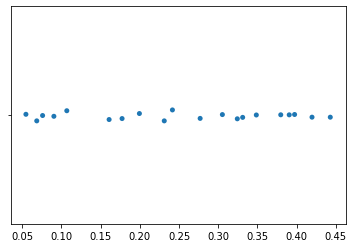

In [16]:
plot1d(xsOf(vectors_new))

## In 3D

In [17]:
def plot3d(vectors):
    xs, ys, zs = unzip(vectors)
    fig = px.scatter_3d(x=xs, y=ys, z=zs)
    fig.show()

In [18]:
# Generate data
xs, ys, zs = gen3dData(5, 2)
xs = normalize(xs)
ys = normalize(ys)
zs = normalize(zs)

In [19]:
# Package data
vectors3d = list(zip(xs, ys, zs))
df = pd.DataFrame(vectors3d)

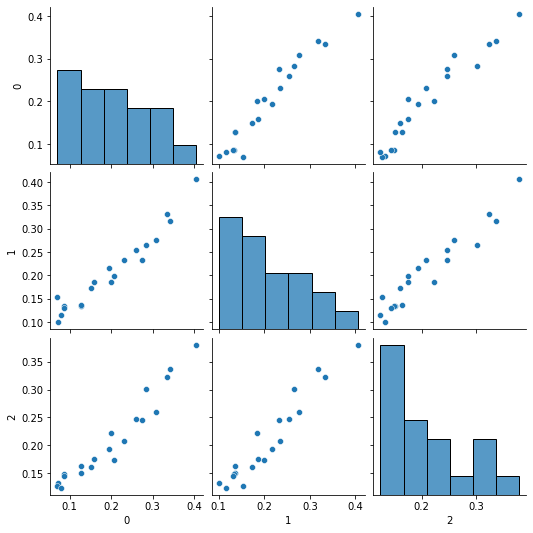

In [20]:
sns.pairplot(df)

In [21]:
plot3d(vectors3d)

In [22]:
# Returns two orthogonal vectors to describe a plan based on the dimension of the space
# and the two axes that should form the plane
def planeToVectors(dimension, axis1, axis2):
    v1 = np.zeros(dimension)
    v2 = np.zeros(dimension)
    v1[axis1] = 1
    v2[axis2] = 1
    return v1, v2

# e.g. In 4D between Y and W axes
#  planeToVectors(4, 1, 3)
#  -> [0 1 0 0], [0 0 0 1]

In [23]:
# Perform a clock-wise rotation by [rotation_deg]° on a list of vectors on the plane described by the two vectors
def rotateOnPlane(plane_v1, plane_v2, rotation_deg, vectors):
    # Create rotation matrix
    rotation_rad = np.radians(rotation_deg)
    M = mgen.rotation_from_angle_and_plane(rotation_rad, plane_v1, plane_v2)

    # Rotate all vectors
    return [M.dot(v) for v in vectors]

In [24]:
# Tries rotating vectors in both directions on the plane given by the two axes (axis1, axis2).
# The direction is chosen that maximises the variance along the optimisation_axis
# 
# Returns (rotation_deg or -rotation_deg), new_variance, rotated_vectors

def bestRotationOnAxes(optimisation_axis, dimension, axis1, axis2, rotation_deg, vectors):
    # Generate orthogonal vectors describing the plane
    plane_v1, plane_v2 = planeToVectors(dimension, axis1, axis2)
    
    # Try rotating left (anti-clockwise)
    vectors_left = rotateOnPlane(plane_v1, plane_v2, -rotation_deg, vectors)
    points = unzip(vectors_left)[optimisation_axis]
    variance_left = stats.variance(points)

    # Try rotating right (clockwise)
    vectors_right = rotateOnPlane(plane_v1, plane_v2, rotation_deg, vectors)
    points = unzip(vectors_right)[optimisation_axis]
    variance_right = stats.variance(points)

    # Choose rotation the maximises the variance
    if variance_left > variance_right:
        return -rotation_deg, variance_left, vectors_left
    else:
        return rotation_deg, variance_right, vectors_right

In [25]:
# Rotates the points by [rotation_deg]° on every plane allowed to improve the variance along the optimisation_axis
# 
# To improve the X-axis alignment, the points are allowed to rotate on every plane,
# but to improve the Y-axis, the rotations may not affect the X-axis alignment
# In 3D: For X-axis alignment rotation on XY and XZ plane (YZ is also allowed, but will not affect X-axis)
#        For Y-axis alignment rotation on YZ, but not YX plane

def improveAxisAlignmentBy(optimisation_axis, dimensions, rotation_deg, vectors):
    if optimisation_axis == dimensions-1:
        points = unzip(vectors)[optimisation_axis]
        return stats.variance(points), vectors
        # TODO

    # Axes to pair with optimisation_axis to form the plane to rotate on.
    # Assumes all axes < optimisation_axis to be fixed and immutable
    for axis2 in range(optimisation_axis+1, dimensions):
        angle_diff, var, vectors = bestRotationOnAxes(
            optimisation_axis = optimisation_axis,
            dimension = dimensions,
            axis1 = optimisation_axis,
            axis2 = axis2,
            rotation_deg = rotation_deg,
            vectors = vectors
        )

    return var, vectors

In [26]:
def optimiseAxisOnPlane(optimisation_axis, dimensions, axis1, axis2, rotation_deg, vectors):
    var_old = -1
    var = 0

    while var > var_old:
        var_old = var
        angle_diff, var, vectors = bestRotationOnAxes(
                optimisation_axis = optimisation_axis,
                dimension = dimensions,
                axis1 = axis1,
                axis2 = axis2,
                rotation_deg = rotation_deg,
                vectors = vectors
            )

    return var, vectors

In [27]:
# axes
class Axis(Enum):
    X,Y,Z = 0,1,2

### Algorithm

In [72]:
def approximatePC(from_dimension, target_pc, precision, vectors):
    # Requires that prior PCs are already approximated in the input vectors

    var_old = -1
    var = 0

    # Instead of improving by a little bit every time, initially make big adjustments and get finer and finer
    # Approach is inspired by binary search.
    angle = 90  # Start at 90° changes instead of 180°, since flipping by 180° results in the same variance
    while angle > precision:
        var_old = var
        var, vectors = improveAxisAlignmentBy(target_pc, from_dimension, angle, vectors)

        angle = angle / 1.5


    return var, vectors

In [73]:
def myPCA(input_vectors, components):
    precision = .1  # Smallest rotation-angle size (in degrees)

    dimensions = len(input_vectors[0])
    target_dimensions = components  # No. of Principal Components to find

    if target_dimensions > dimensions:
        raise Exception(f'Requested more components ({components}) than input data has dimensions ({dimensions})')

    variances = np.zeros(target_dimensions)

    vectors_new = np.copy(input_vectors)

    # Compute Principal Components
    for pc in range(target_dimensions):
            variances[pc], vectors_new = approximatePC(dimensions, pc, precision, vectors_new)

    # Calculate variances explained by components
    total_var = 0
    for points in unzip(input_vectors):
        total_var += stats.variance(points)
    varsExplained = [var / total_var for var in variances]

    return {
        "variance explained": varsExplained,
        "components": unzip(vectors_new)[:target_dimensions]
    }

In [30]:
vectors3d = unzip(genNdData(n=3, size=100))

In [31]:
results = myPCA(vectors3d, 3)
results['variance explained']

[0.5288862848147936, 0.3265388690930836, 0.14457484609213248]

In [32]:
results = myPCA(vectors3d, 3)
results['variance explained']

[0.5288862848147936, 0.3265388690930836, 0.14457484609213248]

In [33]:
vectors5d = unzip(genNdData(n=5, size=100))
results = myPCA(vectors5d, 3)
results['variance explained']

[0.3090840995354638, 0.23240644693238693, 0.20458047818502373]

In [68]:
vectors10d = unzip(genNdData(n=10, size=100))

In [69]:
results = myPCA(vectors10d, 3)
results['variance explained']

[0.1865712065288528, 0.17033919445087034, 0.16157194438610298]

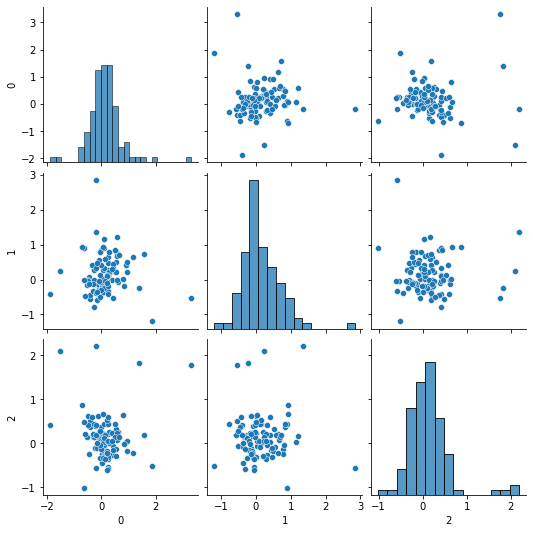

In [36]:
df = pd.DataFrame(unzip(results['components']))
sns.pairplot(df)

In [70]:
# PCA
X = np.ndarray.transpose(np.array(unzip(vectors10d)))

pca = decomposition.PCA(n_components=3)
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.18661317, 0.17031086, 0.16156809])

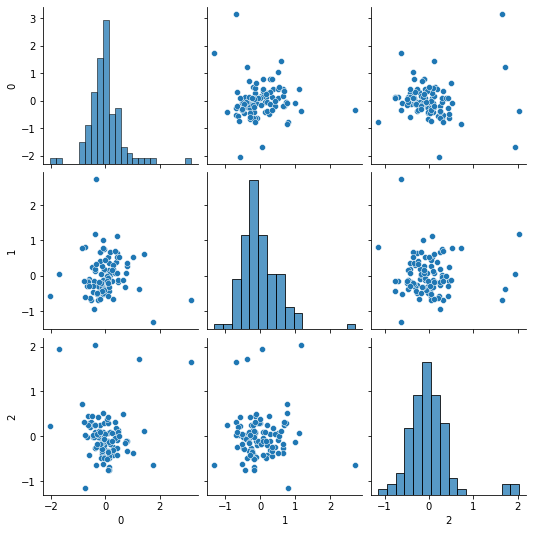

In [38]:
df = pd.DataFrame(X_reduced)
sns.pairplot(df)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c882279-82a6-4796-9acf-70d58cb2aa76' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>